# Librerías:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import calendar

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Lectura de datos:
Se carga el dataset original y modificado para comparar los datos.

In [2]:
original_bike_sharing_df = pd.read_csv('../data/raw/bike_sharing_original.csv')
bike_sharing_df = pd.read_csv('../data/raw/bike_sharing_modified.csv')

In [3]:
target_rows_to_drop = bike_sharing_df.shape[0] - original_bike_sharing_df.shape[0]
target_cols_to_drop = bike_sharing_df.shape[1] - original_bike_sharing_df.shape[1]

print(f'Registros objetivo a eliminar {target_rows_to_drop}')
print(f'Columnas objetivo a eliminar {target_cols_to_drop}')

Registros objetivo a eliminar 347
Columnas objetivo a eliminar 1


# Exploratory Data Analysis (EDA):
- Identificar tipos de datos
- Funciones base de manipulación de datos (eliminar variables, castear valores, etc.)
- Estadísticas descriptivas de los datos
- Identificar valores atípicos & faltantes
- Gráficas para visualizar la distribución por variable

In [4]:
def get_df_info(df):
    df.info()

In [5]:
def get_EDA(df):
    print(df.describe().T)

In [6]:
def get_outliers(df, col):
    percentile_25 = df[col].quantile(0.25)
    percentile_75 = df[col].quantile(0.75)
    iqr = percentile_75 - percentile_25
    upper_limit = percentile_75 + 1.5 * iqr
    lower_limit = percentile_25 - 1.5 * iqr
    IQR_outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    
    return IQR_outliers

In [7]:
def get_NaN_values(df):
    print(f'Valores NaN:\n')
    print(df.isna().sum())

In [8]:
def get_missing_values_by_col(df, col):
    missing_values_mask = df[col].isna()
    
    df_missing_values = df[missing_values_mask].copy()

    return df_missing_values

In [9]:
def get_cat_cols(df):
    cat_cols = df.select_dtypes(include = 'object').columns.tolist()

    return cat_cols

In [10]:
def get_num_cols(df):
    num_cols = df.select_dtypes(exclude = 'object').columns.tolist()

    return num_cols

In [11]:
def get_distribution_summary(df, num_cols):
    summary_data = []
    
    for col in num_cols:
        skew = df[col].skew()
        
        if skew > 0.5:
            skew_interpret = 'Sesgo Derecho (Positivo)'
        elif skew < -0.5:
            skew_interpret = 'Sesgo Izquierdo (Negativo)'
        else:
            skew_interpret = 'Simétrico/Ligero'
        
        
        kurtosis = df[col].kurtosis()

        if kurtosis > 0.5:
            kurtosis_interpret = 'Leptocúrtica (Colas Pesadas)'
        elif kurtosis < -0.5:
            kurtosis_interpret = 'Platicúrtica (Colas Ligeras)'
        else:
            kurtosis_interpret = 'Mesocúrtica (Normal)'

        summary_data.append({
            'Variable': col,
            'Skewness': skew,
            'Kurtosis': kurtosis,
            'Tipo de Sesgo': skew_interpret,
            'Forma de la Distribucion': kurtosis_interpret
        })

    summary_df = pd.DataFrame(summary_data)
    summary_df[['Skewness', 'Kurtosis']] = summary_df[['Skewness', 'Kurtosis']].round(2)
    
    return summary_df

In [12]:
def create_barplots(df, cat_cols, n_rows, n_cols):
    """
    Genera gráficas de barras para variables categóricas.
    
    Args:
        df: dataframe de entrada
        cat_cols: lista de nombres de columnas categóricas
        n_rows: # de filas en el grid de subplots
        n_cols: # de columnas en el grid de subplots
    """

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)

    fig.suptitle('Gráficas de Barras: Variables Categóricas', fontsize=12)

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(cat_cols):
        if i >= len(axes):
            break
        
        ax = axes[i]
        sns.countplot(x=df[col], ax=ax, palette='rocket', legend=False)
        ax.set_title(f'Conteo: {col}', fontsize=12)
        ax.set_xlabel(None)
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=90) 

    # ocultar espacios innecesarios
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [13]:
def create_histograms(df, num_cols, n_rows, n_cols):
    """
    Generar histogramas + KDE para variables numéricas
    
    Params:
        df: dataframe de entrada
        num_cols: lista de columnas numéricas
        n_rows: # de filas en el grid de subplots
        n_cols: # de columnas en el grid de subplots
    """

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    fig.suptitle('Histogramas: Variables Numéricas', fontsize=12)

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(num_cols):
        if i >= len(axes):
            break
        
        ax = axes[i]
        sns.histplot(x=df[col], ax=ax, kde=True, color='skyblue', edgecolor='black')
        ax.set_title(f'Distribución de: {col}', fontsize=12)
        ax.set_xlabel(None)
        ax.set_ylabel('Frecuencia/Densidad')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [14]:
def create_boxplots(df, num_cols, n_rows, n_cols):
    """
    Generar Box Plots para variables numéricas & detectar outliers (IQR)
    
    Args:
        df: dataframe de entrada
        num_cols: lista de nombres de columnas numéricas
        n_rows: # de filas en el grid de subplots
        n_cols: # de columnas en el grid de subplots
    """

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    fig.suptitle('Box Plots / Detección de Outliers (IQR)', fontsize=12)

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(num_cols):
        if i >= len(axes):
            break
        
        ax = axes[i]
        sns.boxplot(x=df[col], ax=ax, showmeans=True)
        ax.set_title(f'Box Plot: {col}', fontsize=12)
        ax.set_xlabel(f'{col}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [15]:
def create_correlation_heatmap(df, num_cols):
    """
    Generar Heatmap para visualizar la matriz de correlación 
    entre las variables numéricas.

    Args:
        df: dataframe de entrada
        num_cols: lista de nombres de columnas numéricas
        figsize: tupla para el tamaño de la figura (width, height)
    """    
    corr_matrix = df[num_cols].corr()

    plt.figure(figsize=(12, 8))
    
    sns.heatmap(
        corr_matrix, 
        annot=True,              
        fmt=".2f",               
        cmap='rocket',         
        linewidths=.5,           
        linecolor='black',       
        cbar_kws={'label': 'Coeficiente de Correlación'}
    )
    
    plt.title('Mapa de Calor de Correlación (Variables Numéricas)', fontsize=12)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout() 

    plt.show()

In [16]:
def drop_cols(df, cols):
    df.drop(columns = cols, inplace=True)
    print(f'Columna (s) {cols} eliminada (s) del dataframe.')

In [17]:
def get_cols_to_drop(baseline_df, modified_df):
    original_cols = set(baseline_df.columns)
    modified_cols = set(modified_df.columns)

    cols_to_drop = []
    diff_cols = modified_cols - original_cols

    if len(diff_cols) == target_cols_to_drop:
        cols_to_drop = diff_cols.pop()
        print(f'Columna (s) a eliminar: {cols_to_drop}')

    return cols_to_drop

In [18]:
def cast_values(df):
        column_types_map = {
            'instant': 'int',
            'season': 'int',
            'yr': 'int',
            'mnth': 'int',
            'hr': 'int',
            'holiday': 'int',
            'weekday': 'int',
            'workingday': 'int',
            'weathersit': 'int',
            'temp': 'float',
            'atemp': 'float',
            'hum': 'float',
            'windspeed': 'float',
            'casual': 'int',
            'registered': 'int',
            'cnt': 'int',
            'mixed_type_col': 'int'
        }

        cast_map = {
            'int': lambda df, col: pd.to_numeric(df[col], errors='coerce').astype('Int64'),
            'float': lambda df, col: pd.to_numeric(df[col], errors='coerce').astype('float64')
        }
        
        for col_name, target_dtype in column_types_map.items():
            if col_name in df.columns:
                cast_map.get(target_dtype.lower())

                cast_action = cast_map.get(target_dtype.lower())

                if cast_action:
                    df[col_name] = cast_action(df, col_name)


In [19]:
get_df_info(bike_sharing_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17726 entries, 0 to 17725
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   instant         17524 non-null  object
 1   dteday          17542 non-null  object
 2   season          17519 non-null  object
 3   yr              17515 non-null  object
 4   mnth            17515 non-null  object
 5   hr              17489 non-null  object
 6   holiday         17552 non-null  object
 7   weekday         17539 non-null  object
 8   workingday      17527 non-null  object
 9   weathersit      17526 non-null  object
 10  temp            17546 non-null  object
 11  atemp           17534 non-null  object
 12  hum             17512 non-null  object
 13  windspeed       17545 non-null  object
 14  casual          17523 non-null  object
 15  registered      17530 non-null  object
 16  cnt             17534 non-null  object
 17  mixed_type_col  15973 non-null  object
dtypes: obj

In [20]:
get_EDA(bike_sharing_df)

                count unique         top   freq
instant         17524  17085       error     23
dteday          17542   1253  2012-09-08     26
season          17519    155         3.0   4243
yr              17515    128         1.0   8224
mnth            17515    190         7.0   1422
hr              17489    218        20.0    701
holiday         17552    101         0.0  16048
weekday         17539    168         6.0   2386
workingday      17527    119         1.0  11225
weathersit      17526    172         1.0  10809
temp            17546    281        0.62    689
atemp           17534    320      0.6212    925
hum             17512    337        0.88    627
windspeed       17545    219         0.0   2076
casual          17523    598         0.0   1493
registered      17530   1227         4.0    294
cnt             17534   1372         5.0    237
mixed_type_col  15973   1002     unknown   1768


In [21]:
cast_values(bike_sharing_df)

In [22]:
get_NaN_values(bike_sharing_df)

Valores NaN:

instant            273
dteday             184
season             264
yr                 274
mnth               282
hr                 293
holiday            249
weekday            246
workingday         262
weathersit         266
temp               236
atemp              252
hum                277
windspeed          247
casual             272
registered         256
cnt                247
mixed_type_col    5265
dtype: int64


In [23]:
cols_to_drop = get_cols_to_drop(original_bike_sharing_df, bike_sharing_df)
drop_cols(bike_sharing_df, cols_to_drop)

Columna (s) a eliminar: mixed_type_col
Columna (s) mixed_type_col eliminada (s) del dataframe.


In [24]:
cat_cols = get_cat_cols(bike_sharing_df)
num_cols = get_num_cols(bike_sharing_df)

In [25]:
print(f'\nAnálisis del sesgo de la distribución (skew) & la forma de la distribución (kurtosis):')
distribution_summary_df = get_distribution_summary(bike_sharing_df, num_cols)
distribution_summary_df


Análisis del sesgo de la distribución (skew) & la forma de la distribución (kurtosis):


Variable  Skewness  Kurtosis             Tipo de Sesgo  \
0      instant     22.90    587.27  Sesgo Derecho (Positivo)   
1       season     17.54    336.03  Sesgo Derecho (Positivo)   
2           yr     19.17    398.62  Sesgo Derecho (Positivo)   
3         mnth     13.57    198.61  Sesgo Derecho (Positivo)   
4           hr     15.30    285.69  Sesgo Derecho (Positivo)   
5      holiday     16.79    299.50  Sesgo Derecho (Positivo)   
6      weekday     91.78  10490.08  Sesgo Derecho (Positivo)   
7   workingday     18.35    356.24  Sesgo Derecho (Positivo)   
8   weathersit     15.71    262.96  Sesgo Derecho (Positivo)   
9         temp     16.71    293.49  Sesgo Derecho (Positivo)   
10       atemp     16.15    277.36  Sesgo Derecho (Positivo)   
11         hum    126.10  16385.38  Sesgo Derecho (Positivo)   
12   windspeed     17.51    326.73  Sesgo Derecho (Positivo)   
13      casual     40.91   2508.27  Sesgo Derecho (Positivo)   
14  registered     37.32   1903.00  Sesgo Derecho (Positivo)   
15         cnt     25.68    803.28  Sesgo Derecho (Positivo)   

        Forma de la Distribucion  
0   Leptocúrtica (Colas Pesadas)  
1   Leptocúrtica (Colas Pesadas)  
2   Leptocúrtica (Colas Pesadas)  
3   Leptocúrtica (Colas Pesadas)  
4   Leptocúrtica (Colas Pesadas)  
5   Leptocúrtica (Colas Pesadas)  
6   Leptocúrtica (Colas Pesadas)  
7   Leptocúrtica (Colas Pesadas)  
8   Leptocúrtica (Colas Pesadas)  
9   Leptocúrtica (Colas Pesadas)  
10  Leptocúrtica (Colas Pesadas)  
11  Leptocúrtica (Colas Pesadas)  
12  Leptocúrtica (Colas Pesadas)  
13  Leptocúrtica (Colas Pesadas)  
14  Leptocúrtica (Colas Pesadas)  
15  Leptocúrtica (Colas Pesadas)

In [26]:
print(f'\nAnálisis de Valores Atípicos:')

for col in num_cols:
    outliers_df = get_outliers(bike_sharing_df, col)
    
    if len(outliers_df) > 0:
        print(f'\n[{col}]\n')
        print(outliers_df) 
    else:
        print(f'\nNo se encontraron resultados para [{col}]')
    
    print('_' * 40)


Análisis de Valores Atípicos:

[instant]

       instant        dteday  season  yr  mnth  hr  holiday  weekday  \
535      48240    2011-01-24       1   0     1  11        0        1   
642      36008    2011-01-30       1   0     1   1        0        0   
653      33354   2011-01-30        1   0     1  13        0        0   
654      63535    2011-01-30       1   0     1  14        0        0   
1035     66304    2011-02-15       1   0     2  20        0        2   
...        ...           ...     ...  ..   ...  ..      ...      ...   
16360  1177992    2012-11-19       4   1    11  10        0        1   
16399   869200    2012-11-21       4   1    11   1        0        3   
17493  1309860    2012-12-25       1   1    12  23        1        2   
17542   938174    2012-04-04       2   1     4  16        0        3   
17684   190355    2012-12-28       1   1    12  21        0        5   

       workingday  weathersit  temp   atemp    hum  windspeed  casual  \
535             1  

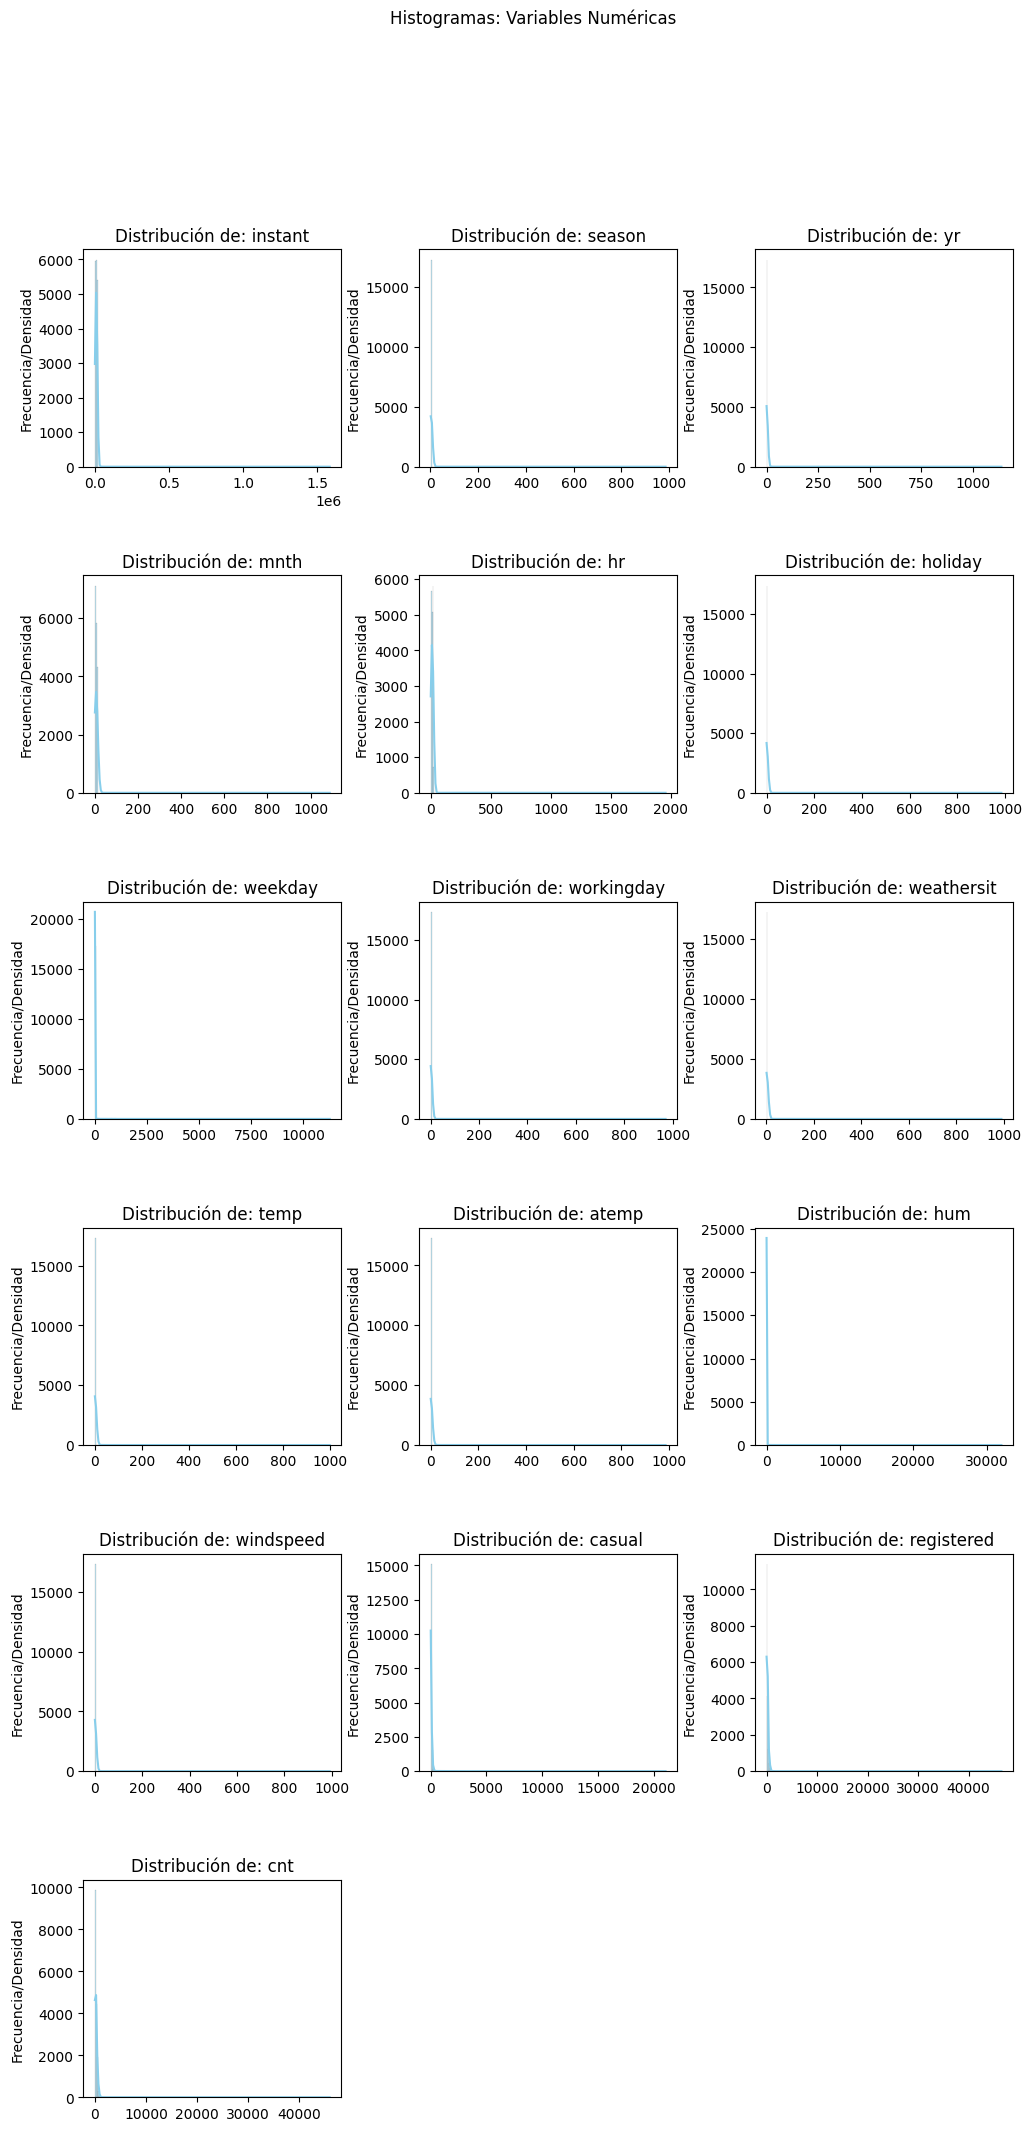

In [27]:
create_histograms(bike_sharing_df, num_cols, 6, 3)

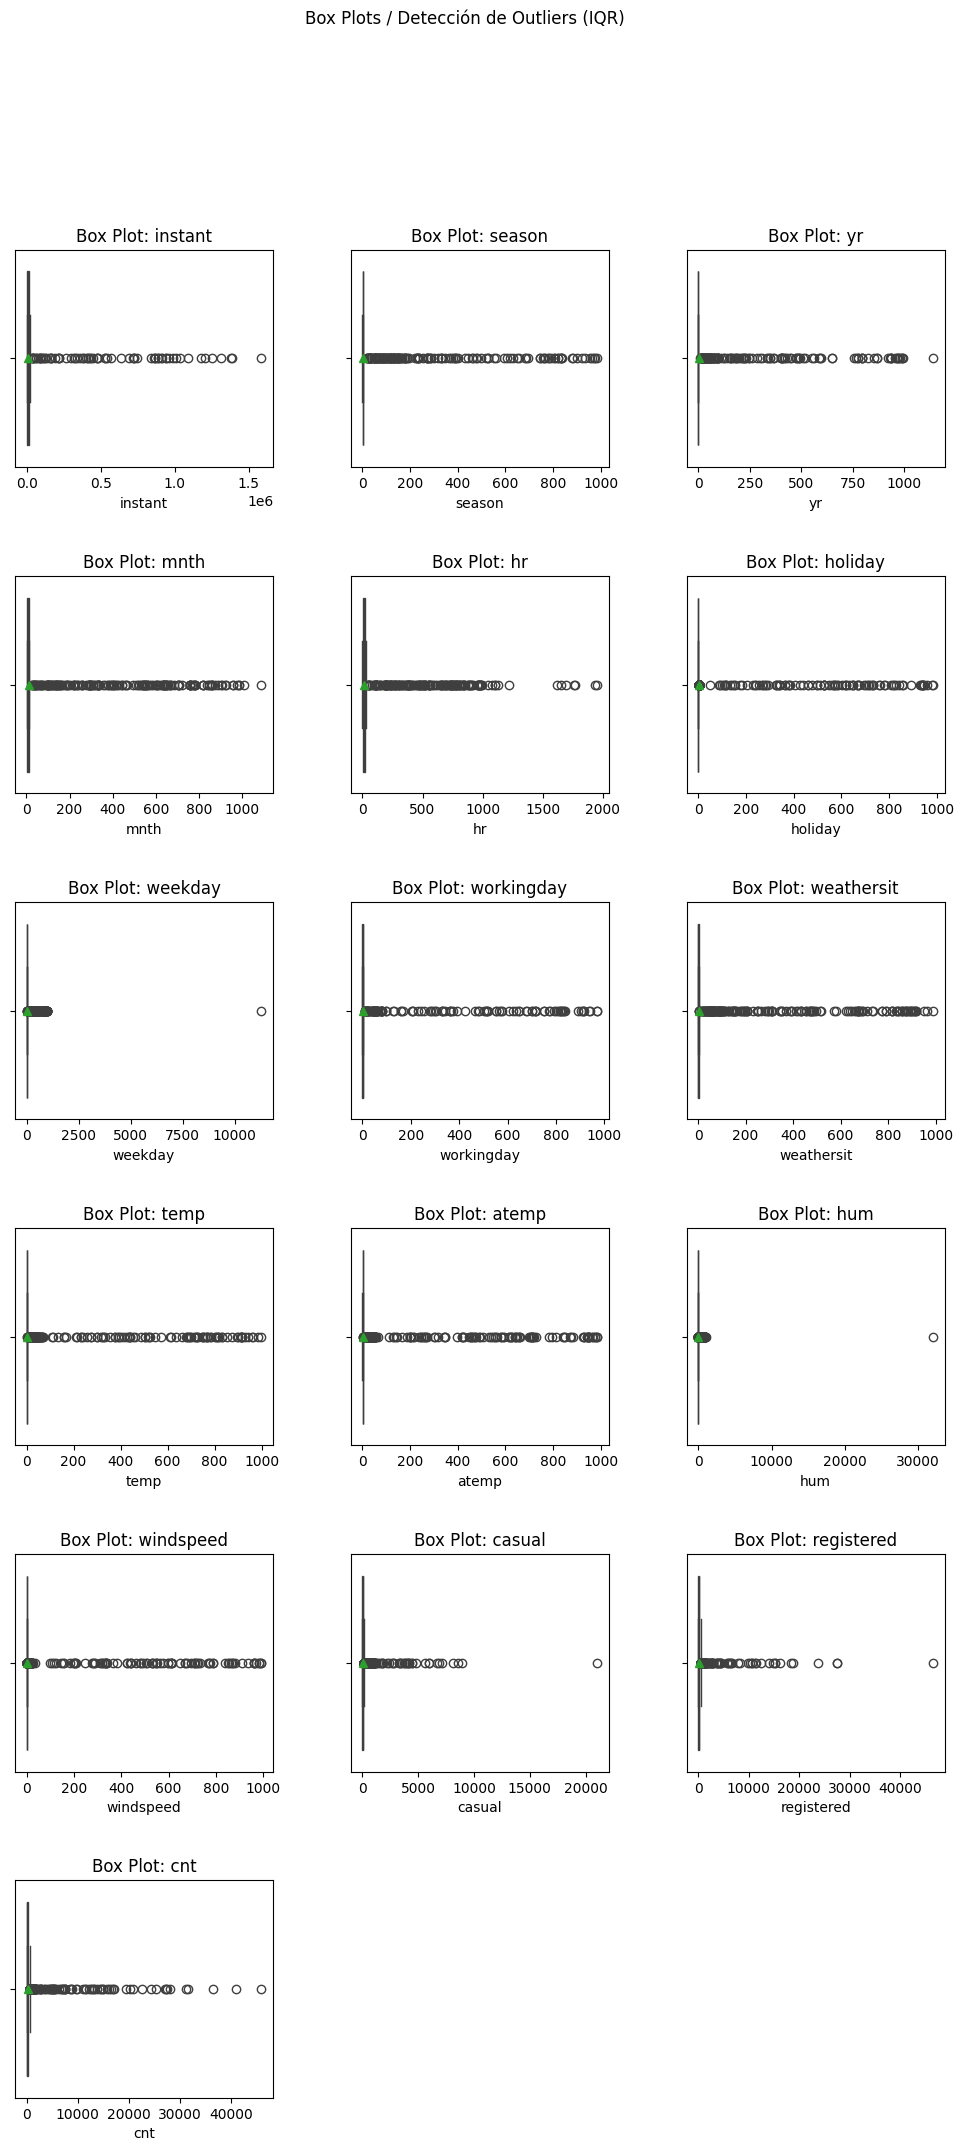

In [28]:
create_boxplots(bike_sharing_df, num_cols, 6, 3)

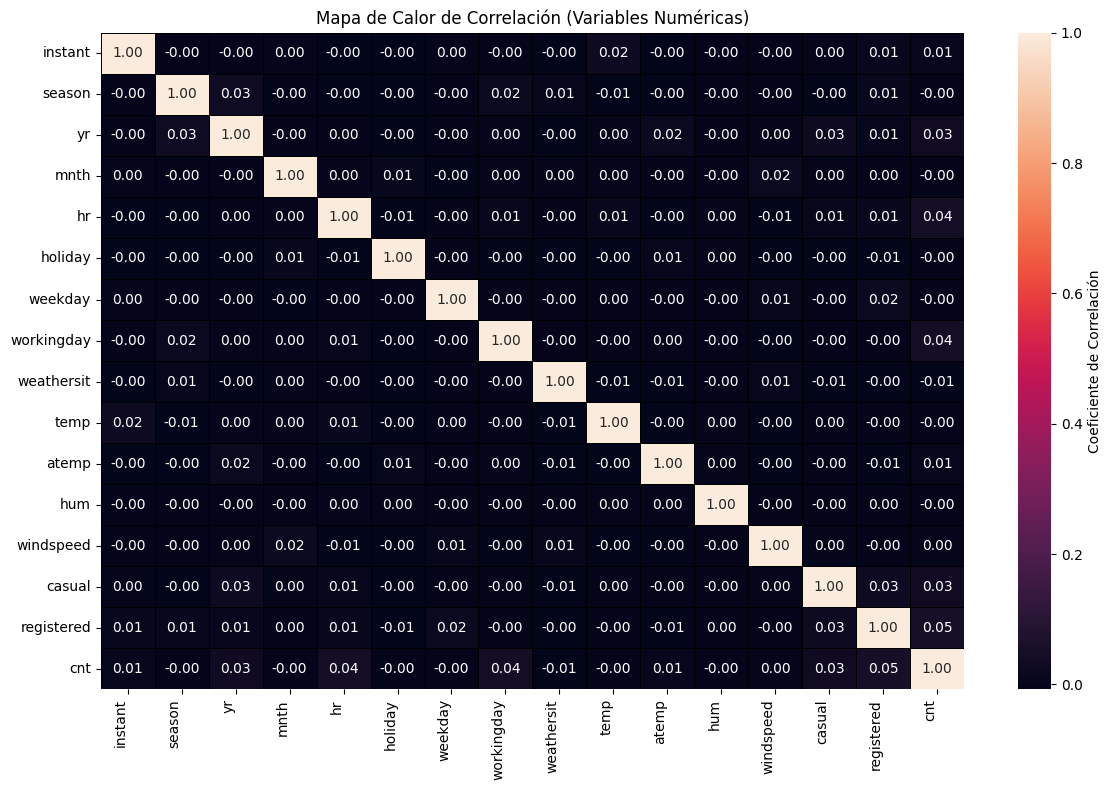

In [29]:
create_correlation_heatmap(bike_sharing_df, num_cols)